# Mathematical Underpinnings - Lab 1
# Krzyziński Mateusz

## Task 1
### a) Generative approach 

We know $\pi = P(Y=1)$ and the distributions $f(x|Y=1)$ and $f(x|Y=-1)$.

#### First bullet point

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# set seed for reproducibility
np.random.seed(42) 

In [3]:
# sampling from multivariate normal distribution and from Bernoulli
x = np.random.multivariate_normal(np.array([0,0]), np.eye(2), 5)
y = np.random.binomial(1, 0.5, 5)
x, y

(array([[ 0.49671415, -0.1382643 ],
        [ 0.64768854,  1.52302986],
        [-0.23415337, -0.23413696],
        [ 1.57921282,  0.76743473],
        [-0.46947439,  0.54256004]]),
 array([0, 0, 0, 1, 0]))

In [4]:
m1 = np.array([1,1])
m2 = np.array([0,0])

sigma = np.array([[1, -0.5],[-0.5, 1]])

In [5]:
# sampling
Y_generative = np.repeat([1, 0], 500)

In [6]:
n1 = 500
n2 = 500
X_generative = np.zeros((1000, 2))
X_generative[:n1, :] = np.random.multivariate_normal(m1, sigma, n1)
X_generative[n1:, :] = np.random.multivariate_normal(m2, sigma, n2)

Does the distribution of $P(Y=1|X=x)=p(y=1|x)$ correspond to a logistic model?

A hint: Use Bayes theorem to compute $p(y=1|x)$. Is it possible to represent $p(y=1|x)$ as $\frac{e^{\beta_0 + \beta x}}{1 + e^{\beta_0 + \beta x}}$?


**Solution:**

Starting from Bayes theorem, we have:
$$P(Y=1|x) = \frac{P(X=x|Y=1) \cdot P(Y=1)}{P(X=x)} = \frac{p(x|y=1)\pi}{p(x)},$$

where $p(x)$ by the law of total probability is:
$$p(x) = p(x|y=1)\pi + p(x|y=-1)(1-\pi).$$

Thus, we have:
$$P(Y=1|x) = \frac{p(x|y=1)\pi}{p(x|y=1)\pi + p(x|y=-1)(1-\pi)}.$$

We can divide the numerator and the denominator by $p(x|y=1)\pi$ to get:
$$P(Y=1|x) = \frac{1}{1 + \frac{p(x|y=-1)(1-\pi)}{p(x|y=1)\pi}}.$$

Thus to get a logistic model, the second component of the denominator must be equal to $\exp(-\beta_0 - \beta x)$. This is the case if:

$$\exp(-\beta_0 - \beta x) = \frac{1-\pi}{\pi} \cdot \frac{p(x|y=-1)}{p(x|y=1)}.$$

$$-\beta_0 - \beta x = \log \frac{1-\pi}{\pi} + \log \frac{p(x|y=-1)}{p(x|y=1)}.$$

$$-\beta_0 - \beta x = -\log \frac{1-\pi}{\pi} - \log \frac{C \cdot \exp(-\frac{1}{2}(x-\mu_2)^T \Sigma^{-1} (x-\mu_2))}{C \cdot \exp(-\frac{1}{2}(x-\mu_1)^T \Sigma^{-1}  (x-\mu_1))}.$$

Note that the constant $C = \frac{1}{(2\pi)^{p/2} |\Sigma|^{1/2}}$ cancels out and after taking the logarithm, the exponentials cancel out as well, leaving us with:

$$-\beta_0 - \beta x = -\log \frac{1-\pi}{\pi} - \frac{1}{2}(x-\mu_2)^T \Sigma^{-1} (x-\mu_2) + \frac{1}{2}(x-\mu_1)^T \Sigma^{-1} (x-\mu_1)$$

Then, we see that 

$$\frac{1}{2}(x-\mu_2)^T \Sigma^{-1} (x-\mu_2) = \frac{1}{2}[x^T \Sigma^{-1} x - 2 \mu_2^T \Sigma^{-1} x + \mu_2^T \Sigma^{-1} \mu_2]$$

and similarly for the component with $\mu_1$.

So we can write the equation as:

$$ -\beta_0 - \beta x = -\log \frac{1-\pi}{\pi} - \frac{1}{2}[\mu_2^T \Sigma^{-1} \mu_2 - \mu_1^T \Sigma^{-1} \mu_1] + x^T  \Sigma^{-1}  (\mu_2 - \mu_1)$$

Finally, we have: 

$$\beta_0 = \log \frac{1-\pi}{\pi} + \frac{1}{2} \mu_2^T \Sigma^{-1} \mu_2 - \frac{1}{2} \mu_1^T \Sigma^{-1} \mu_1,$$ 

$$\beta = \Sigma^{-1} \cdot (\mu_1 - \mu_2).$$


#### Second bullet point

Find the formulas for the parameters of the logistic model (the coefficients and the intercept).

A hint: Use the representation of $p(y=1|x)$ from the first bullet point and solve for $\beta_0$ and $\beta$.

**Solution:** Formulas are given in the first bullet point.

In [7]:
# computing beta_0 and beta using the formulas
pi = 0.5
sigma_inv = np.linalg.inv(sigma)

beta_0 = np.log((1-pi) / pi) + 0.5 * m2 @ sigma_inv @ m2 - 0.5 * m1 @ sigma_inv @ m1
print(beta_0)

beta = sigma_inv @ (m1 - m2)
print(beta)

-2.0
[2. 2.]


In [8]:
# a logistic model
mod_a = LogisticRegression(penalty=None)
mod_a.fit(X_generative, Y_generative)
(mod_a.intercept_, mod_a.coef_)

(array([-2.17308482]), array([[2.08548934, 2.15465732]]))

### b) Discriminative approach

We know $f(x)$ and $P(Y=1|X=x)$.

#### First bullet point

In [9]:
mixture_1_k = np.random.binomial(1000, 0.5, 1)[0]
mixture_1_k # number of samples from the first part of the mixture (instead of sampling from a Bernoulli) 

527

In [10]:
# sampling
X_disciminative = np.zeros((1000, 2))
X_disciminative[:mixture_1_k, :] = np.random.multivariate_normal(m1, sigma, mixture_1_k)
X_disciminative[mixture_1_k:, :] = np.random.multivariate_normal(m2, sigma, 1000 - mixture_1_k)
beta_0 = -2 
beta = np.array([2, 2])
Y_probs = 1 / (1 + np.exp(-X_disciminative @ beta - beta_0))
Y_discriminative = np.random.binomial(1, Y_probs)

In [11]:
mod_b = LogisticRegression(penalty=None)
mod_b.fit(X_disciminative, Y_discriminative)

LogisticRegression(penalty=None)

In [12]:
print(mod_b.intercept_) 
print(mod_b.coef_)

[-1.95734814]
[[2.01233293 1.91172204]]


#### Second bullet point

In [13]:
# randomize the order of observations in the datasets to make the plots look better 
permutation = np.random.permutation(1000)
X_generative = X_generative[permutation, :]
Y_generative = Y_generative[permutation]
X_disciminative = X_disciminative[permutation, :]
Y_discriminative = Y_discriminative[permutation]

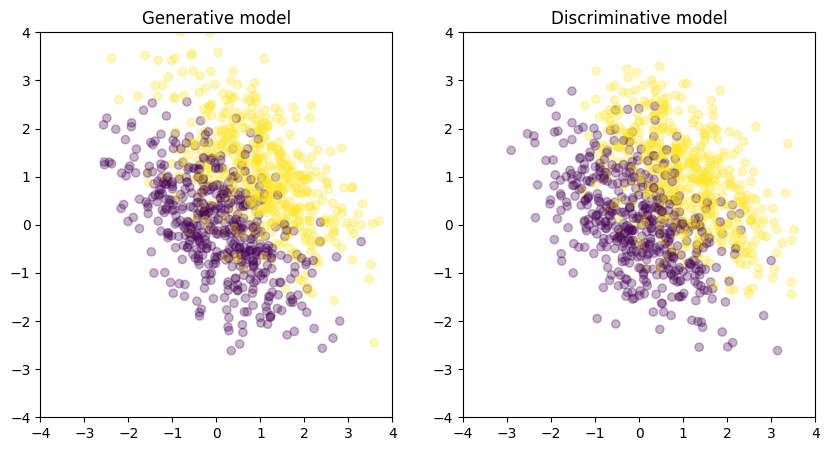

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_generative[:, 0], X_generative[:, 1], c=Y_generative, alpha=0.3)
plt.ylim(-4,4)
plt.xlim(-4,4)
plt.title('Generative model')
plt.subplot(1, 2, 2)
plt.scatter(X_disciminative[:, 0], X_disciminative[:, 1], c=Y_discriminative, alpha=0.3)
plt.ylim(-4,4)
plt.xlim(-4,4)
plt.title('Discriminative model')
plt.show()

What distinguishes the generative approach from the discriminative approach?

We see no difference by looking at the scatter plots, so joint distribution $P_{X,Y}$ is the same in both cases. The differences lay in the modeling point of view, for example in generative approach we control $\pi$ but have to know it, while in discriminative approach we control $P(Y=1|X=x)$ but can estimate $\pi$ from the data. 

### c)

To sample from $f_{X|Y=-1}$, first, we will give an answer to Q1.

Q1. A hint: use Bayes theorem for $p(x|y=-1)$ and use law of total probability for $p(x)$.

**Solution:**

Starting from Bayes theorem, we have:
$$P(X|Y=-1) = \frac{P(Y=-1|X=x) \cdot P(X=x)}{P(Y=-1)} = \frac{p(y=-1|x) \cdot p(x)}{p(y=-1)},$$

where $p(x)$ by the law of total probability is:
$$p(x) = p(x|y=1)p(y=1) + p(x|y=-1)p(y=-1).$$

Thus, we have:
$$p(x|y=-1) = \frac{p(y=-1|x) \cdot [p(x|y=1)p(y=1) + p(x|y=-1)p(y=-1)]}{p(y=-1)},$$

so: 

$$p(x|y=-1) - \frac{p(y=-1|x) \cdot p(x|y=-1) \cdot p(y=-1)}{p(y=-1)} =  \frac{p(y=-1|x) \cdot p(x|y=1) \cdot p(y=1)}{p(y=-1)}.$$

After reducing $p(y=-1)$, we get:

$$p(x|y=-1) \cdot [1 - p(y=-1|x)] =  p(y=-1|x) \cdot p(x|y=1) \cdot \frac{p(y=1)}{p(y=-1)}.$$

We can substitute $p(y=1|x) = 1 - p(y=-1|x)$ and get:

$$p(x|y=-1) \cdot p(y=1|x) =  p(y=-1|x) \cdot p(x|y=1) \cdot \frac{p(y=1)}{p(y=-1)}.$$

Then, we can divide both sides by $p(y=1|x)$ to get:

$$p(x|y=-1) =  p(x|y=1) \cdot \frac{p(y=1)}{p(y=-1)} \cdot \frac{p(y=-1|x)}{p(y=1|x)}.$$

Note that the last component is the inverse of odds ratio, so following the logistic model, we can write:

$$p(x|y=-1) =  p(x|y=1) \cdot \frac{p(y=1)}{p(y=-1)} \cdot \frac{1}{\exp(\beta_0 + \beta x)},$$

which can be rewritten as:

$$p(x|y=-1) =  p(x|y=1) \cdot \frac{p(y=1)}{p(y=-1)} \cdot \exp(-\beta_0) \cdot \exp(-\beta x).$$

In this task, we have:
- $p(x|y=1) = \lambda \exp(-\lambda x) \cdot \mathbb{I}_{x \geq 0}$,
- $\lambda = 1$
- $p(y=1) = \pi = 1/3$,
- $p(y=-1) = 1 - \pi = 2/3$,
- $\beta_1 = 1.$

So we can write:

$$p(x|y=-1) = \exp(-x) \cdot \frac{1}{2} \cdot \exp(-\beta_0) \cdot \exp(-x),$$

which can be simplified to:

$$p(x|y=-1) = \frac{\exp(-\beta_0)}{2} \cdot \exp(-2x).$$

We can see that the distribution is an exponential distribution with parameter $\lambda = 2$. 

Moreover, since the integral of the probability distribution is equal to 1, it is easy to see that $\frac{\exp(-\beta_0)}{2} = 2$. 

So $\beta_0$ is uniquely determined, i.e., $\beta_0 = -\log(4)$. 

Finally, to sum up: 

$$ p(x|y=-1) \sim \text{Exp}(2),$$
$$ \beta_0 = -\log(4).$$

In general, to have the proper distribution, we need to have:
$$C_{\beta_0, \pi} = \exp(-\beta_0) \frac{\pi}{1-\pi},$$
and $C_{\beta_0, \pi} = \beta_1+1$, so we can write:
$$ \beta_0 = -\log( (\beta_1 + 1) \frac{1-\pi}{\pi}).$$

In [15]:
# sampling
beta1 = 1
lambda1 = 1
lambda2 = beta1 + 1

n1 = 1000
x1 = np.random.exponential(1/lambda1, size=n1)

n2 = 2000
x2 = np.random.exponential(1/lambda2, size=n2)

In [16]:
X = np.concatenate([x1, x2]).reshape(-1, 1)
y = np.concatenate([np.repeat(1, n1), np.repeat(-1, n2)])

In [17]:
# a model
mod = LogisticRegression(penalty=None)
mod.fit(X, y)

LogisticRegression(penalty=None)

In [18]:
print(mod.intercept_)
print(mod.coef_)

[-1.41288607]
[[1.09675778]]


Q2, Q3. A hint: what is the distribution of $f_{X|Y=-1}$? What ia a norming constant?

**Solution:** 

- The distribution of $f_{X|Y=-1}$ is an exponential distribution with parameter $\lambda = 2$. 
- Once $\pi$ is fixed, we do not have freedom to choose intercept in this model. 
- Intercept $\beta_0$ depends on $\pi$.


If that is doable, given $\beta_1$ and $\pi$ compute $\beta_0$.

A hint: Of course it is, compute $\beta_0$.

**Solution:** (see above) $\beta_0 = -\log(4)$.

In [19]:
pi_c = n1/(n1 + n2)
beta0 = - np.log((beta1 + 1) * (1 - pi_c) / pi_c)
beta0 # theoretical value of beta_0

-1.3862943611198908

In [20]:
- np.log(4)

-1.3862943611198906

## Task 2

### a)

$R(a,a^*) = \mathbb{E} \mathcal{L}(f(X), Y) = \mathbb{E}(aX - Y)^2 = ...$,

In our task we know $a^* = 1$.

In [268]:
# def population_risk(a, sigma_eps):
#     return ...

### b)

In [269]:
# sampling

Empirical risk: $\frac{1}{n} \sum_{i=1}^n (ax_i - y_i)^2$

In [270]:
# def empirical_risk(a, x, y):
#     return ...

### c)

In [37]:
# code, plot

### d)

Excess risk: $$E(\hat a, a^*) =R(\hat a, a^*) - \textrm{inf}_{a \in A_0} R(a, a^*)$$

In [38]:
# excess risk
# ...

In [39]:
# simulations with fixed sample size

In [276]:
# simulations for various sample sizes

In [40]:
# a nice plot visualising the results (how the unconditional excess risk changes with a sample size)